# Examples I - Inferring $v_{\rm rot}$ By Minimizing the Line Width

This Notebook intends to demonstrate the method used in [Teague et al. (2018a)](https://ui.adsabs.harvard.edu/#abs/2018ApJ...860L..12T) to infer the rotation velocity as a function of radius in the disk of HD 163296. The following [Notebook](Examples%20-%20II.ipynb) demonstrates the updated method presented in Teague et al. (2018b) which relaxes many of the assumptions used in this Notebook.

## Idea

For this method to work we make the assumption that the disk is azimuthally symmetric (note that this does not mean that the emission we observe in symmetric, but only that the underlying disk structure is). Therefore, if we were to observe the line profile at different azimuthal angles for a given radius, they should all have the same shape. What will be different is the line centre due to the line-of-sight component of the rotation,

$$v_0 = v_{\rm LSR} + v_{\rm rot} \cdot \cos \theta$$ 

where $i$ is the inclination of the disk, $\theta$ is the azimuthal angle measured from the red-shifted major axis and $v_{\rm LSR}$ is the systemic velocity.

It has already been shown by assuming a rotation velocity, for example from fitting a first moment map, each spectrum can be shifted back to the systemic velocity and then stacked in azimuth to boost the signal-to-noise of these lines (see [Yen et al. (2016)](https://ui.adsabs.harvard.edu/#abs/2016ApJ...832..204Y) for a thorough discussion on this and [Teague et al. (2016)](https://ui.adsabs.harvard.edu/#abs/2016A&A...592A..49T) and [Matrà et al. (2017)](https://ui.adsabs.harvard.edu/#abs/2017ApJ...842....9M) for applications of this).

---

![Example of shifted spectra.](Images/shiftedlineprofiles.png)

In the above image, the left hand side shows data for TW Hya and the typical Keplerian rotation pattern. An annulus with a radius of 1 arcsecond is shown by the dotted line and then three spectra, shown on the right in gray, are extracted at the dots. By shifting the velocity axis of each of this by $v_{\rm rot} \cdot \cos \theta$ they are aligned along the systemic velocity, $v_{\rm LSR}$, and able to be stacked (shown in blue).

---

However, this only works correctly if we know the rotation velocity. If an incorrect velocity is used to deproject the spectra then the line centres will be scattered around the systemic velocity. When these lines are stacked, the resulting profile will be broader with a smaller amplitude. We can therefore assert that the correct velocity used to derproject the spectra is the one which _minimises the width of the stacked line profile_. One could make a similar argument about the line peak, however with noisy data this is a less strict constraint as this relies on one channel (the one containing the line peak) rather than the entire line profile.

## Application

This approach is relatively simple to code up with Python. We consider the case of very high signal-to-noise data, however it also works well with low signal-to-noise data, as we describe below.

First we make the velocity axis (assuming a systemic velocity of 0 km/s to make things easier) and build spectra assuming a Gaussian shape. For real data one would have to define an annulus of some width and take all the spectra and their polar angles from that. In the case of highly optically thick lines, such as $^{12}{\rm CO}$, one needs to take into account the flaring of the disk meaning that annuli of equal radius are no longer ellipses ([Pinte et al., 2018a](https://ui.adsabs.harvard.edu/#abs/2018A&A...609A..47P)).

In [1]:
%matplotlib inline
import numpy as np
import scipy.constants as sc
import matplotlib.pyplot as plt
np.random.seed(42)

In [2]:
def gaussian(x, x0, dx, A):
    """Simple Gaussian function."""
    return A * np.exp(-np.power((x-x0)/dx, 2))

In [3]:
# Creating the model spectra.
# Velocity axis with a channel width of 30 m/s.

velax = np.arange(-1980, 2001, 30)

# Line-of-sight velocities. We use 20 lines, evenly spaced in theta and assume a vrot of 1500 m/s,
# roughly the projected Keplerian rotation around a solar mass star at 100 au in a disk inclined by
# 30 degrees.

vrot = 1500.
theta = np.linspace(-np.pi, np.pi, 21)[1:]
v_los = vrot * np.cos(theta)

# Assume a Gaussian profile with brightness temperature of 40K and a width of 150 m/s, roughly
# the Doppler width of a thermally broadened CO line at 40K. We also add Gaussian (and independent)
# random noise to this assuming a SNR in each line of 20, so the RMS = 2K.

width = 150.
peak = 40.
rms = 2.

lines = gaussian(velax[None, :], v_los[:, None], width, peak)
lines += rms * np.random.randn(lines.size).reshape(lines.shape)

We can plot the lines to check what they look like. Due to projection effects with real data there will be a higher density of points at low $v_0$ values, however for this demonstration this difference does not matter.

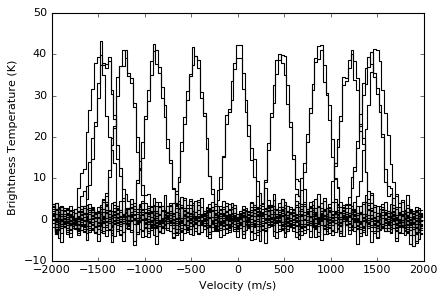

In [4]:
fig, ax = plt.subplots()
for line in lines:
    ax.step(velax, line, where='mid', color='k')
ax.set_xlabel('Velocity (m/s)')
ax.set_ylabel('Brightness Temperature (K)')

We now write some functions which will help us with the deprojection:

* `deprojected_spectra` - This should take all the spectra and their position angles and shift their velocity axis by the provided $v_{\rm rot}$ value. The returned axes are sorted in increasing velocity.


* `deprojected_spectrum` - This takes the results of `deprojected_spectra` and stacks the lines by binning onto the original velocity axis. The reason these functions are separate will become apparent later.


* `get_spectrum_width` - Uses `scipy.optimize.curve_fit` to fit a Gaussian profile to the provided spectrum and returns the width. As this doesn't use bounds we take the absolute width to avoid negative values. In the case a Gaussian can't be fit, we return a very large number rather than a `NaN` to help with the minimization.


* `spectrum_width` - The function to be used for our call to `scipy.optimize.minimize`. Allow us to either resample the deprojected data back down to the original sampling or not.

In [5]:
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit

def deprojected_spectra(spectra, angles, velax, vrot):
    """Return (x, y) of the deprojected points."""
    vpnts = velax[None, :] - vrot * np.cos(angles)[:, None]
    return np.squeeze(zip(*sorted(zip(vpnts.flatten(), spectra.flatten()))))
    
def deprojected_spectrum(spectra, angles, velax, vrot):
    """Return (x, y) of deprojected spectra, binned to original axes.."""
    dV = 0.5 * np.diff(velax)[0]
    vpnts, spnts = deprojected_spectra(spectra, angles, velax, vrot)
    spectrum = binned_statistic(vpnts, spnts, statistic='mean', bins=velax.size,
                                range=(velax[0]-dV, velax[-1]+dV))[0]
    return velax, spectrum

def get_spectrum_width(velax, spectrum):
    """Return the absolute width of a Gaussian fit."""
    Tb = np.max(spectrum)
    x0 = velax[spectrum.argmax()]
    dx = np.trapz(spectrum, velax) / Tb / np.sqrt(2. * np.pi)
    p0 = [x0, dx, Tb]
    try:
        popt, _ = curve_fit(gaussian, velax, spectrum,
                            p0=p0, maxfev=100000)
        return abs(popt[1])
    except:
        return 1e50
    
def spectrum_width(v, spectra, angles, velax, resample=True):
    """Return the spectrum from a Gaussian fit."""
    if resample:
        x, y = deprojected_spectrum(spectra, angles, velax, v)
    else:
        x, y = deprojected_spectra(spectra, angles, velax, v)
        mask = np.logical_and(x >= velax[0], x <= velax[-1])
        x, y = x[mask], y[mask]
    return get_spectrum_width(x, y)

To demonstrate the differences between `deprojected_spectra` and `deprojected_spectrum` we can plot their results assuming the correct rotation velocity. Note that before the binning down we extend the velocity range by a large amount so it is useful to clip this back to the range we're interested in.

The binning also reduces the noise in the resulting spectra. For independent Gaussian uncertainties, the new RMS of the line will be a factor of $\sqrt{N}$ less, where $N$ is the number of spectra uses. Although this will not strictly be the improvement in the noise (due to spatial correlations in the data), this demonstrates why this method can be used even at the outer edges of disks where traditional moment map methods fail.

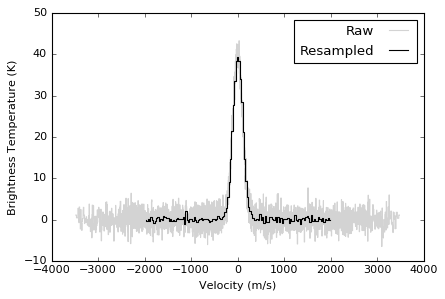

In [6]:
fig, ax = plt.subplots()

# Plot the results of deprojecred_spectra() which does not
# bin the data to the original velocity axix.

x, y = deprojected_spectra(lines, theta, velax, vrot)
ax.step(x, y, where='mid', color='lightgray', label='Raw')

# Compare the same reult but stacking the lines.

x, y = deprojected_spectrum(lines, theta, velax, vrot)
ax.step(x, y, where='mid', color='k', label='Resampled')

ax.legend(markerfirst=False)
ax.set_xlabel('Velocity (m/s)')
ax.set_ylabel('Brightness Temperature (K)')

We can easily demonstate that true $v_{\rm rot}$ minimizes the width of the stacked line by comparing how the width of the resulting line varies as a function of $v_{\rm rot}$.

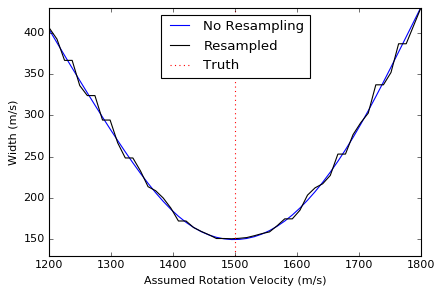

In [7]:
# Consider the range between 80% and 120% of the true value.

v_test = np.linspace(0.8, 1.2, 50) * vrot

fig, ax = plt.subplots()

# Calculate the width of the averaged line profile with and without
# resampling back down to the original reosolution.

widths = [spectrum_width(v, lines, theta, velax, resample=False) for v in v_test]
ax.plot(v_test, widths, color='b', label='No Resampling')

widths = [spectrum_width(v, lines, theta, velax, resample=True) for v in v_test]
ax.plot(v_test, widths, color='k', label='Resampled')

# Mark on the true rotation velocity and linewidth.

ax.axvline(vrot, ls=':', color='r', label='Truth')
#ax.axhline(150., ls=':', color='r')

ax.set_ylim(130, 430)
ax.legend(loc=9)
ax.set_xlabel('Assumed Rotation Velocity (m/s)')
ax.set_ylabel('Width (m/s)')

We can then wrap up all these functions to a simple one which uses `scipy.minimize_scalar` to find the correct rotation velocity. Sometimes with noisy data it is good to give a guess (maybe from a simple Keplerian profile) to bound the search.

In [8]:
from scipy.optimize import minimize_scalar

def get_vrot(spectra, angles, velax, guess=None, resample=True):
    """Wrapped to find vrot by minimizing the width."""
    if guess is None:
        bounds = (0.0, velax.max())
    else:
        bounds = np.array([0.7, 1.3]) * guess
    return minimize_scalar(spectrum_width, bounds=bounds, method='bounded',
                           args=(spectra, angles, velax, resample)).x

In [9]:
print("True value: %.2f m/s" % vrot)
print("Inferred value (with binning): %.2f m/s" % get_vrot(lines, theta, velax, resample=True, guess=1500.))
print("Inferred value (without binning): %.2f m/s" % get_vrot(lines, theta, velax, resample=False, guess=1500.))

True value: 1500.00 m/s
Inferred value (with binning): 1501.90 m/s
Inferred value (without binning): 1498.06 m/s


This method is also very quick (although it doesn't return uncertainties) making it quick to apply to your data.

In [10]:
%timeit get_vrot(lines, theta, velax, resample=True, guess=1500.)

10 loops, best of 3: 54.3 ms per loop


Even when we increase the number of pixels.

In [11]:
vrot = 1500.
theta = np.linspace(-np.pi, np.pi, 301)[1:]
v_los = vrot * np.cos(theta)
lines = gaussian(velax[None, :], v_los[:, None], 150., 40.)
lines += 2. * np.random.randn(lines.size).reshape(lines.shape)

In [12]:
%timeit get_vrot(lines, theta, velax, resample=True, guess=1500.)

1 loop, best of 3: 1.09 s per loop


If we have a reasonable enough prior and enough spectra to stack, we are able to still find a well constrained result.
As mentioned before, the quality of the fit depends on the SNR of the stacked spectrum rather than the raw data. Thus we can account for low SNR data at the edge of the disk with the increases number of beams we average over.

Similarly, we do not need exceptionally high velocity resolution as the $v_{\rm rot} \cdot \cos \theta$ shift for each spectrum allows us to sample the intrinsic line profile at a much higher effective resolution.